In [1]:
%matplotlib inline

import sys
import os
import gym
import numpy as np
import matplotlib
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools
from collections import namedtuple
if '../' not in sys.path:
    sys.path.append('../')
    
from lib.envs.cliffwalking import CliffWalkingEnv
from lib import plots

In [2]:
env = CliffWalkingEnv()
action_size = env.action_space.n
action_size

4

In [18]:
# Create Policy Estimator Network
# A simple lookup table
class PolicyEstimator:
    """
    Policy Function Approximator.
    """
    def __init__(self, lr=0.01):
        with tf.variable_scope("PolicyEstimator"):
            self.state = tf.placeholder(tf.int32, [], name="state")
            self.action = tf.placeholder(tf.int32, name="action")
            self.target = tf.placeholder(tf.float32, name="target")
            
            # state to onehot 
            state_one_hot = tf.one_hot(self.state, depth=int(env.observation_space.n))
            self.output = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(state_one_hot, 0),
                num_outputs=env.action_space.n,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.action_probs = tf.squeeze(tf.nn.softmax(self.output))
            self.picked_action_prob = tf.gather(self.action_probs, self.action)
            
            # calculate loss
            self.loss = -tf.log(self.picked_action_prob) * self.target
            self.optimizer = tf.train.AdamOptimizer(learning_rate=lr)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = {self.state: state}
        prediction = sess.run(self.action_probs, feed_dict)
        return prediction  
    
    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = {self.state: state, self.action: action, self.target: target}
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [19]:
class ValueEstimator:
    """
    Value Function Aproximation.
    """
    def __init__(self, learning_rate=0.01):
        with tf.variable_scope("ValueEstimator"):
            self.state = tf.placeholder(tf.int32, [], name="state")
            self.target = tf.placeholder(tf.float32, name="target")
            
            state_one_hot = tf.one_hot(self.state, depth=int(env.observation_space.n))
            self.output = tf.contrib.layers.fully_connected(inputs=tf.expand_dims(state_one_hot, 0),
                                                            num_outputs=1,
                                                            activation_fn=None,
                                                            weights_initializer=tf.zeros_initializer)
            self.estimate = tf.squeeze(self.output)
            self.loss = tf.squared_difference(self.estimate, self.target)
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: state }
        return sess.run(self.estimate, feed_dict)
    
    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [36]:
def reinforce_without_baseline(env, estimator_policy, num_episodes, discount_factor=1.0):
    """
    REINFORCE (Monte Carlo Policy Gradient) Algorithm. Optimizes the policy
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_reward
    """
    stats = plots.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    
    Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # reset environment
        state = env.reset()
        
        trajectory = []
        
        for t in itertools.count():
            # get next action
            action_probs = estimator_policy.predict(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            
            trajectory.append(Transition(state=state,
                                         action=action, 
                                         reward=reward, 
                                         next_state=next_state, 
                                         done=done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")
            sys.stdout.flush()
            
            if done:
                break
            
            state = next_state
        
        for t, transition in enumerate(trajectory):
            # total return from this time step
            total_return = sum(discount_factor**i * tr.reward for i, tr in enumerate(trajectory[t:]))
            
            # update the policy estimator with total return as target Vanilla REINFORCE
            estimator_policy.update(transition.state, total_return, transition.action)

    return stats

In [37]:
tf.reset_default_graph()
global_step = tf.Variable(0, name="global_step", trainable=False)
estimator_policy = PolicyEstimator()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    stats = reinforce_without_baseline(env, estimator_policy, 2000)

Step 17 @ Episode 2000/2000 (-17.0)))

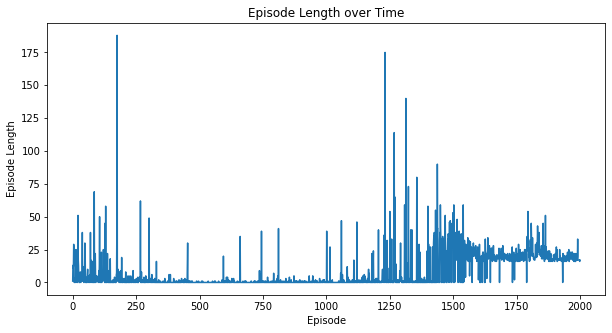

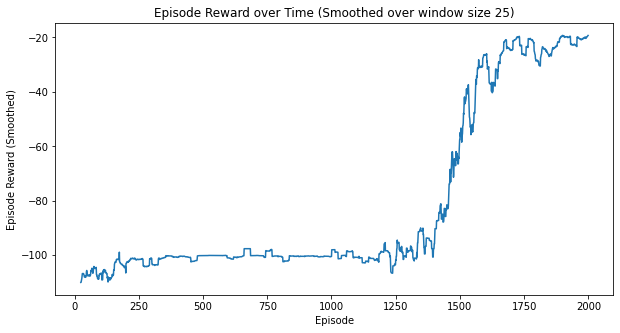

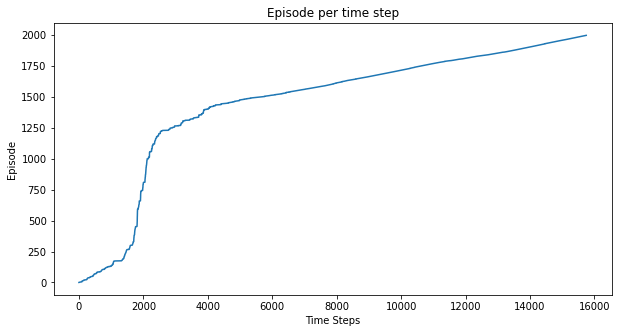

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [38]:
plots.plot_episode_stats(stats, smoothing_window=25)

In [23]:
# Reduced Variance
def reinforce_with_baseline(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    REINFORCE (Monte Carlo Policy Gradient) Algorithm. Optimizes the policy
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a baseline
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_reward
    """
    stats = plots.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    
    Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # reset environment
        state = env.reset()
        
        trajectory = []
        
        for t in itertools.count():
            # get next action
            action_probs = estimator_policy.predict(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            
            trajectory.append(Transition(state=state,
                                         action=action, 
                                         reward=reward, 
                                         next_state=next_state, 
                                         done=done))
            
            # store statistics
            stats.episode_lengths[i_episode] = t
            stats.episode_rewards[i_episode] += reward
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")
            sys.stdout.flush()

            
            if done:
                break
            
            state = next_state
        
        for t, transition in enumerate(trajectory):
            # total return from this time step
            total_return = sum((discount_factor**i)*tr.reward for i, tr in enumerate(trajectory[t:]))
            
            # caluculate estimated_value from value_estimator
            estimated_value = estimator_value.predict(transition.state)
            advantage = total_return - estimated_value
            
            estimator_value.update(transition.state, estimated_value)
            estimator_policy.update(transition.state, advantage, transition.action)
    return stats

In [25]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator()
value_estimator = ValueEstimator()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Note, due to randomness in the policy the number of episodes you need to learn a good
    # policy may vary. ~2000-5000 seemed to work well for me.
    stats = reinforce_with_baseline(env, policy_estimator, value_estimator, 2000, discount_factor=1.0)

Step 18 @ Episode 2000/2000 (-17.0))

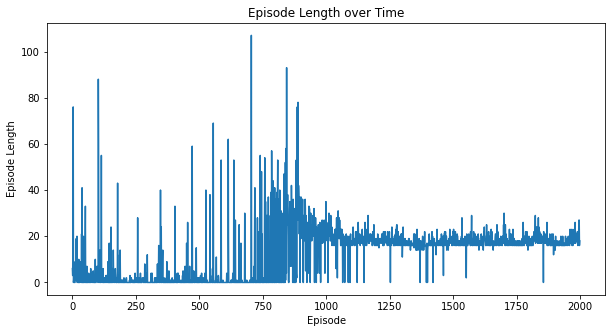

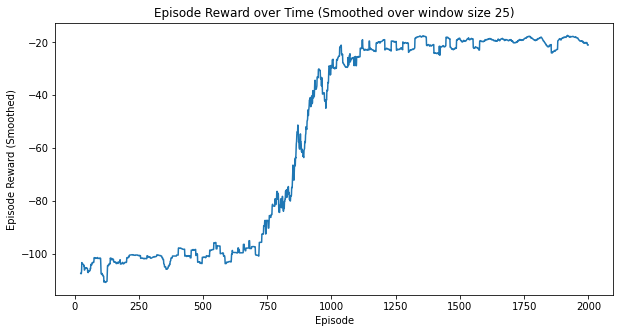

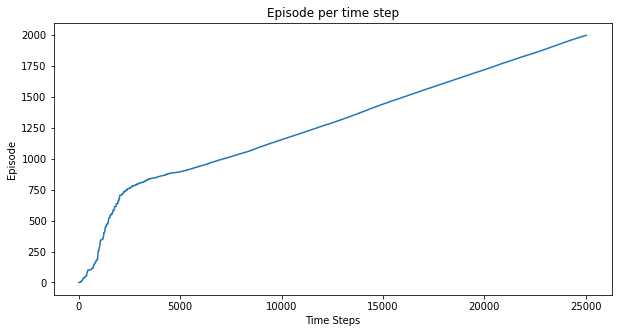

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [26]:
plots.plot_episode_stats(stats, smoothing_window=25)